# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images issues de Google Quickdraw (https://quickdraw.withgoogle.com/data).
Le jeu de données proposé comprend 5 classes balancées, avec 15000 exemples d'apprentissage et 5000 exemples de validation : des paniers, des yeux, des lunettes, des lapins et des mains.

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur la base originale que nous conservons, pour voir si les résultats que vous proposez sont reproductibles. 

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous expliquerez votre démarche, justifierez vos choix, commenterez vos expérimentations et vos résultats.

La notation sera construite de la manière suivante : 
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test. Les binômes seront classés par taux de reconnaissance décroissant, les premiers ayant 8 points accordés, les autres binômes ayant une note suivant une décroissance linéaire.

Le notebook sera déposé sur la plateforme moodle du cours.

##Introduction

Ce notebook jupyter réalise la phase d'apprentissage de notre réseau ainsi que son enregistrement et en utilisant les données présentes dans l'archive "Data_Train_Valid.zip" présente sur le cours en ligne.

Ce notebook a été réalisé par : Yahya ABOURRICHE

## Imports

On commence par importer quelques librairies nécessaires pour le bon fonctionnement notre projet :

In [59]:
import tensorflow
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Ajouter les imports nécessaires

import os
import cv2
import matplotlib
matplotlib.use("Agg")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

Afin de pouvoir accéder à nos fichiers, on les importe à notre google drive sous format zip.

Ensuite, on réalise un *mount* du drive afin de pouvoir accéder aux fichiers à partir de notre notebook jupyter.

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Afin de pouvoir accéder aux fichiers, on décompresse notre fichier .zip et on met son contenu dans le chemin standard.

In [6]:
!unzip drive/MyDrive//Data_Train_Valid.zip > /dev/null

## Données

On crée une liste *classes* contenant les classes de catégories d'images.

Puis on créé 2 *panda dataframes* : une contenant les données présentes dans le fichier d'entrainement train.csv, et l'autre contenant les données présentes dans le fichier de validation valid.csv.

In [7]:
classes = ["basket","eye","binoculars","rabbit","hand"]
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

On affiche la taille de la dataframe d’entrainnemen *train* et on la visualise.

On remarque que chaque ligne de *train* contient un nom d'image, son chemin relatif et son label.

In [10]:
print(train.shape)
train

(75000, 3)


,image_name,relative_path,class_label
0,basket_052681.png,basket/basket_052681.png,0
1,basket_028248.png,basket/basket_028248.png,0
2,basket_050738.png,basket/basket_050738.png,0
3,basket_034414.png,basket/basket_034414.png,0
4,basket_091738.png,basket/basket_091738.png,0
...,...,...,...
74995,hand_241467.png,hand/hand_241467.png,4
74996,hand_052619.png,hand/hand_052619.png,4
74997,hand_168727.png,hand/hand_168727.png,4
74998,hand_285523.png,hand/hand_285523.png,4


On affiche la taille de la dataframe de validation *valid* et on la visualise.

On remarque que chaque ligne de *valid* contient un nom d'image, son chemin relatif et son label.

train et valid ont un format similaire.

In [11]:
print(valid.shape)
valid

(25000, 3)


,image_name,relative_path,class_label
0,basket_091236.png,basket/basket_091236.png,0
1,basket_111908.png,basket/basket_111908.png,0
2,basket_088296.png,basket/basket_088296.png,0
3,basket_040763.png,basket/basket_040763.png,0
4,basket_010714.png,basket/basket_010714.png,0
...,...,...,...
24995,hand_125273.png,hand/hand_125273.png,4
24996,hand_133214.png,hand/hand_133214.png,4
24997,hand_112700.png,hand/hand_112700.png,4
24998,hand_219816.png,hand/hand_219816.png,4


On parcourt un peu la dataframe *train* afin de se familariser avec elle :

In [12]:
train.iloc[20000,:]


image_name           eye_092148.png
relative_path    eye/eye_092148.png
class_label                       1
Name: 20000, dtype: object

Au début, on a travaillé juste avec train en traitant les données, puis on les séparant en données d'entrainnement et données de test.

Mais vu l'existence de la dataframe valid, cela n'est pas nécessaire.

Donc, il suffit de commenter cela et travailler directement avec train et valid.

In [13]:
#train.iloc[0,1]
#data=[]
#label=[]
#for i in range(0,train.shape[0]):
#  im = Image.open('images/'+ train.iloc[i,1])
#  image = img_to_array(im)
#  data.append(image)
#  label.append(train.iloc[i,2])
#len(data)

In [14]:
#dat = np.array(data, dtype="float") / 255.0
#labels = np.array(label)

In [15]:
#(trainX, testX, trainY, testY) = train_test_split(dat,
#	labels, test_size=0.25, random_state=42)

## Préparation des Données

On prépate d'abord les données d’entraînement.

Pour réaliser cela, on crée 2 listes : 
  - trainX qui contiendra les images sous formes d'*arrays* en utilisant *img_to_array*.
  - trainY qui contiendra les labels (sous format int : 0,1,2,3,4 selon l'ordre dans la liste classes).

Puis, pour chaque élément de la dataframe *train*, on ouvre l'image associé (trouvé grâce au chemin relatif, 2ème colonne) et on la transforme en *array* en utilisant img_to_array puis on l'ajoute dans la liste trainX et on ajoute son label dans la liste trainY.

In [16]:
trainX=[]
trainY=[]
for i in range(0,train.shape[0]):
  im = Image.open('images/'+ train.iloc[i,1])
  image = img_to_array(im)
  trainX.append(image)
  trainY.append(train.iloc[i,2])
len(trainX)

75000

On prépate ensuite les données de validation.

Pour réaliser cela, on crée 2 listes : 
  - testX qui contiendra les images sous formes d'*arrays* en utilisant *img_to_array*.
  - testY qui contiendra les labels (sous format int : 0,1,2,3,4 selon l'ordre dans la liste classes).

Puis, pour chaque élément de la dataframe *test*, on ouvre l'image associé (trouvé grâce au chemin relatif, 2ème colonne) et on la transforme en *array* en utilisant img_to_array puis on l'ajoute dans la liste testX et on ajoute son label dans la liste testY.

In [17]:
testX=[]
testY=[]
for i in range(0,valid.shape[0]):
  im = Image.open('images/'+ valid.iloc[i,1])
  image = img_to_array(im)
  testX.append(image)
  testY.append(valid.iloc[i,2])
len(testX)

25000

Ensuite, on transforme nos listes créées en des *numpy arrays* avec pour les images des valeurs divisées par 255.0 (afin d'otenir des valeurs entre 0 et 1).

In [18]:
trainX = np.array(trainX, dtype="float") / 255.0
testX = np.array(testX, dtype="float") / 255.0
trainY = np.array(trainY)
testY = np.array(testY)

##Visualisation


Afin de vérifier que nos modifications n'ont pas ruinés nos images, on essaye alors de les visualiser.
On réalise une visualisation initiale de nos images avant qu'on les a modifiés :

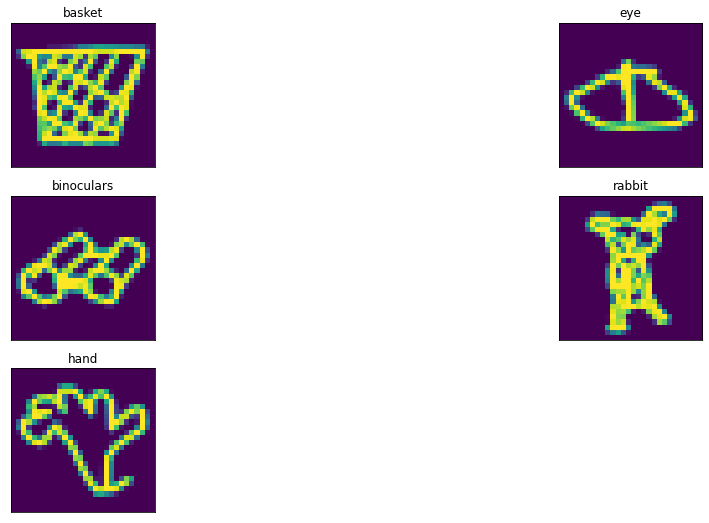

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(3,2 ,i+1)
    mydata = pd.read_csv("train.csv",skiprows = [1], nrows=1)
    im = Image.open('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0])
    fig=ax.imshow(im)
    plt.title(classes[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    

Puis, on visualise nos images modifiées directement à partir de la liste trainX (liste contenant les images sous forme d'arrays) en utilisant *imshow* pour afficher les images et *squeeze* afin d'obtenir des résultats cohérents.

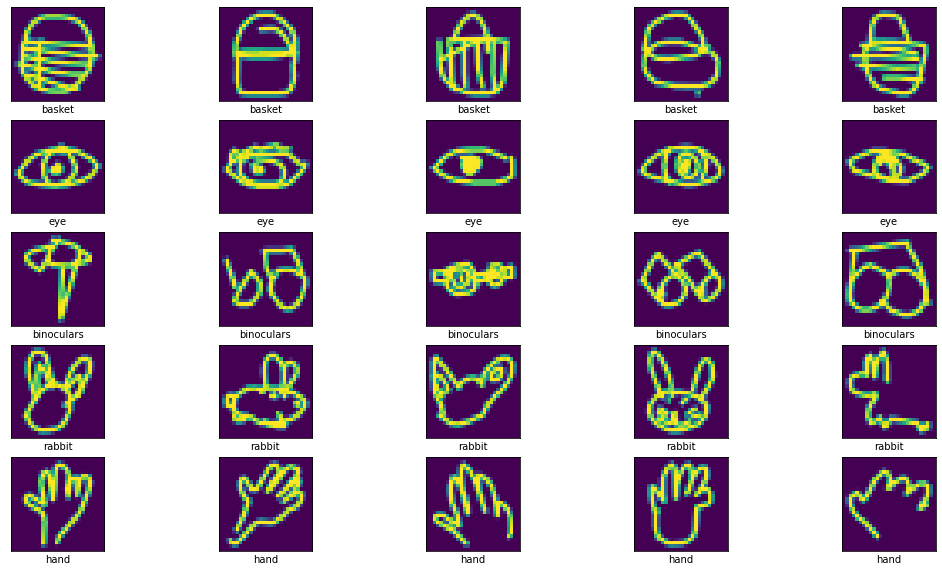

In [32]:
plt.figure(figsize=(18,10))
for i in range(25):
    j = (len(trainX)//25)*i   #Afin d'avoir de la diversité, on choisit d'afficher 5 images de chaque types
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[j].squeeze())
    plt.xlabel(classes[trainY[j]])
plt.show()

On remarque ainsi que nos images sont bien adaptées et elles sont en même taille (si ce n'était pas le cas, on aurait pu réaliser un reshape afin d'adapter nos images et les donner tous une taille similaire).
Nos images sont déja en forme (28, 28, 1).

##Entraînement Model

On commence par notre modèle basique. Un CNN avec 3 *Convolutional Layers* suivies par des *max pooling layers*

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(56, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(56, (3, 3), activation='relu'))
#model.summary()
model.add(Flatten())
model.add(Dense(56, activation='relu'))
model.add(Dense(5))
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 24, 24, 28)        728       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 28)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 56)          39256     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 4, 4, 56)         0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 1, 1, 56)          50232     
                                                                 
 flatten_7 (Flatten)         (None, 56)               

On compile le model avec l'optimiseur Adam et avec SparseCategoricalCrossentropy comme fonction de perte. 
On entraine le model sur 10 epoch.

In [56]:
import tensorflow as tf

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=10, 
                    validation_data=(testX, testY))

Epoch 1/5
2344/2344 [==============================] - 75s 32ms/step - loss: 0.3492 - accuracy: 0.8836 - val_loss: 0.2148 - val_accuracy: 0.9296
Epoch 2/5
2344/2344 [==============================] - 68s 29ms/step - loss: 0.1885 - accuracy: 0.9372 - val_loss: 0.1720 - val_accuracy: 0.9405
Epoch 3/5
2344/2344 [==============================] - 69s 29ms/step - loss: 0.1503 - accuracy: 0.9490 - val_loss: 0.1810 - val_accuracy: 0.9395
Epoch 4/5
2344/2344 [==============================] - 68s 29ms/step - loss: 0.1282 - accuracy: 0.9567 - val_loss: 0.1580 - val_accuracy: 0.9474
Epoch 5/5
2344/2344 [==============================] - 68s 29ms/step - loss: 0.1095 - accuracy: 0.9629 - val_loss: 0.1624 - val_accuracy: 0.9477


On évalue alors le résultat obtenu par ce modèle initial :
On affiche la courbe de précision :

On obtient alors avec 10 epochs : accuracy=0.9821 val_accuracy: 0.9489

et avec 5 epochs : accuracy=0.9629 et val_accuracy=0.9477

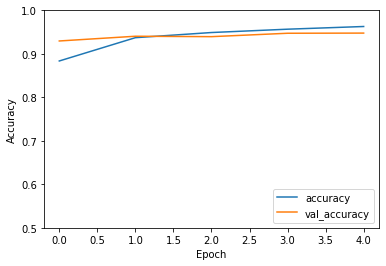

782/782 - 6s - loss: 0.1624 - accuracy: 0.9477 - 6s/epoch - 8ms/step
0.9477199912071228
0.16239675879478455


In [57]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.show()

test_loss, test_acc = model.evaluate(testX,  testY, verbose=2)
print(test_acc)
print(test_loss)

On enregistre notre modèle sous forme h5 : 

In [52]:
model.save("mon_model_h5.h5")

On refait le travail sur ce modèle en changeant le taux d'entrainement *learning_rate* afin de voir si ça modifie le résultat

In [ ]:
model2 = Sequential()
model2.add(Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(56, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(56, (3, 3), activation='relu'))
#model.summary()
model2.add(Flatten())
model2.add(Dense(56, activation='relu'))
model2.add(Dense(5))
model2.summary()

In [49]:
EP = 25
ILR = 1e-3
BS = 32
import tensorflow as tf

opt = Adam(lr=ILR, decay=ILR / EP)

model2.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model2.fit(trainX, trainY, epochs=EP, 
                    validation_data=(testX, testY))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
2344/2344 [==============================] - 61s 26ms/step - loss: 0.3405 - accuracy: 0.8870 - val_loss: 0.2184 - val_accuracy: 0.9258
Epoch 2/10
2344/2344 [==============================] - 69s 29ms/step - loss: 0.1907 - accuracy: 0.9357 - val_loss: 0.1760 - val_accuracy: 0.9409
Epoch 3/10
2344/2344 [==============================] - 73s 31ms/step - loss: 0.1531 - accuracy: 0.9481 - val_loss: 0.1630 - val_accuracy: 0.9437
Epoch 4/10
2344/2344 [==============================] - 81s 35ms/step - loss: 0.1289 - accuracy: 0.9558 - val_loss: 0.1530 - val_accuracy: 0.9476
Epoch 5/10
2344/2344 [==============================] - 66s 28ms/step - loss: 0.1106 - accuracy: 0.9622 - val_loss: 0.1588 - val_accuracy: 0.9482
Epoch 6/10
2344/2344 [==============================] - 68s 29ms/step - loss: 0.0961 - accuracy: 0.9671 - val_loss: 0.1668 - val_accuracy: 0.9488
Epoch 7/10
2344/2344 [==============================] - 65s 28ms/step - loss: 0.0836 - accuracy: 0.9711 - val_loss: 0.1606 -

En donnant un taux d’entraînement *learning_rate* égal à 0.001 avec 10 epochs, on obtient un résultat similaire : 

accuracy = 0.9823 et val_accuracy=0.9504.



On peut augmenter le nombre d'épochs (25) afin d'obtenir un meilleur résultat.

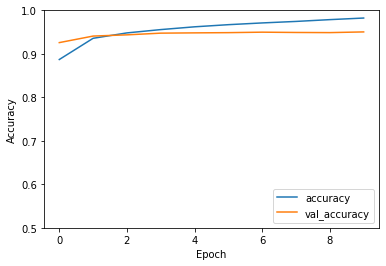

782/782 - 6s - loss: 0.1852 - accuracy: 0.9504 - 6s/epoch - 7ms/step
0.950439989566803
0.1851518750190735


In [50]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.show()

test_loss, test_acc = model.evaluate(testX,  testY, verbose=2)
print(test_acc)
print(test_loss)

J'ai essayé aussi de tester d'autres modèles un peu plus approfondies, mais cela n'a pas conduit à des résultats intéressants

In [ ]:
#from keras.layers import Dropout

#model = Sequential()
#model.add(Conv2D(28,(3,3),activation='relu',input_shape=(28,28,1)))
#model.add(Conv2D(28,(3,3),activation='relu', padding='same'))
#model.add(Conv2D(112,(3,3),activation='relu', padding='same'))
#model.add(Conv2D(112,(3,3),activation='relu', padding='same'))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(.3))
#model.add(Conv2D(224, (3,3), activation='relu', padding='same'))
#model.add(Conv2D(224, (3,3), activation='relu', padding='same'))
#model.add(Conv2D(112, (3,3), activation='relu', padding='same'))
#model.add(Conv2D(112, (3,3), activation='relu', padding='same'))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(.3))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dense(896, activation='relu'))
#model.add(Dense(448, activation='relu'))
#model.add(Dropout(.3))
#model.add(Flatten())
#model.add(Dense(28, activation='relu'))
#model.add(Dense(5, activation='sigmoid'))
#model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 28)        280       
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 28)        7084      
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 112)       28336     
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 112)       113008    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 112)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 112)       0         
                                                      

On réalise un pip freeze afin d'obtenir les librairies et dépenndances.

In [58]:
pip freeze > requirements.txt